#De-biased HT Ad Classification
----

## Overview
- Working with 2017 Spring QPR data adjusted for bias per Ben and Fahd's work: https://www.memexproxy.com/wiki/display/MPM/De-biasing+Spring+2017+CP1+Data
- After the de-biasing process, there are 511 total clusters in the training data (53 positive, 458 negative)
- Test set is unchanged with 130 clusters (25 pos, 105 neg) 

## Approach
#### Preprocessing
- Used NER to remove any dates and locations found (potential sources of bias)
- Lemmatized
- Removed standard stopwords as well as custom list developed by analyzing model features from LinearSVC runs (mostly locations not identified by NER)
- Used unigrams and bigrams
- Used CountVectorizer (slow but retains ngram-to-vector mapping) to create vectors (HashingVectorizer is much faster but ngram-to-vector mapping is lost and features can't be analyzed)

#### Modeling
- LinearSVC (retain feature importance) for classification 

**Full discussion and analysis here:** https://www.memexproxy.com/wiki/display/MPM/De-biased+HT+Ad+Classification 

In [2]:
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import json
import json_lines
import re
import pandas as pd
import itertools
import spacy
import csv
import time
import numpy as np

# Preprocessing

### Make sure clusters used for training match Ben and Fahd's list

The following clusters weren't emptied when processing according to Ben and Fahd's process (need to investigate, just removed for now)
- d7442551917e16fb1414adacff1a6261e2732eb1
- 7a9af586f3824a0baa0d889cc4d56c3014f05fde
- acfe5b0f70dff69e6ee670ee72dfb9d7fd14abc7
- b3e3e882cd3be6bdd9602ef36be0f1380243b81d
- 3fdc6a9537fe45f0fda27a4cd64a471cc024404e
- b3d356ad021bab2568dede78285a9f4dfd9e8f95
- 236aa9e8a9cf7c74fde7320491394368f91d8ccd
- c28e17a100187bebdd91f48d8d80bdec4d327553

In [22]:
# Look at which clusters should have been emptied but weren't
empty_clusters = []
with open("debiasing-data/empty_clusters.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        empty_clusters.append(row[0].lower())

### Compare cluster sizes before and after de-biasing

In [141]:
def get_cluster_sizes(filename):
    sizes = {}
    
    with open(filename, "r") as f:
        for doc in json_lines.reader(f):
            if not doc["cluster_id"] in sizes:
                sizes[doc["cluster_id"]] = 1
            else:
                sizes[doc["cluster_id"]] += 1
    
    return sizes
            
orig_cluster_sizes = get_cluster_sizes("test-train-data/train_adjusted.json")
debiased_cluster_sizes = get_cluster_sizes("test-train-data/debiased_training.json")
test_cluster_sizes = get_cluster_sizes("test-train-data/test_adjusted_unlabeled.json")

In [119]:
labels = []
orig = []
debiased = []

for c in debiased_cluster_sizes.keys():
    labels.append(c)
    orig.append(orig_cluster_sizes[c])
    debiased.append(debiased_cluster_sizes[c])

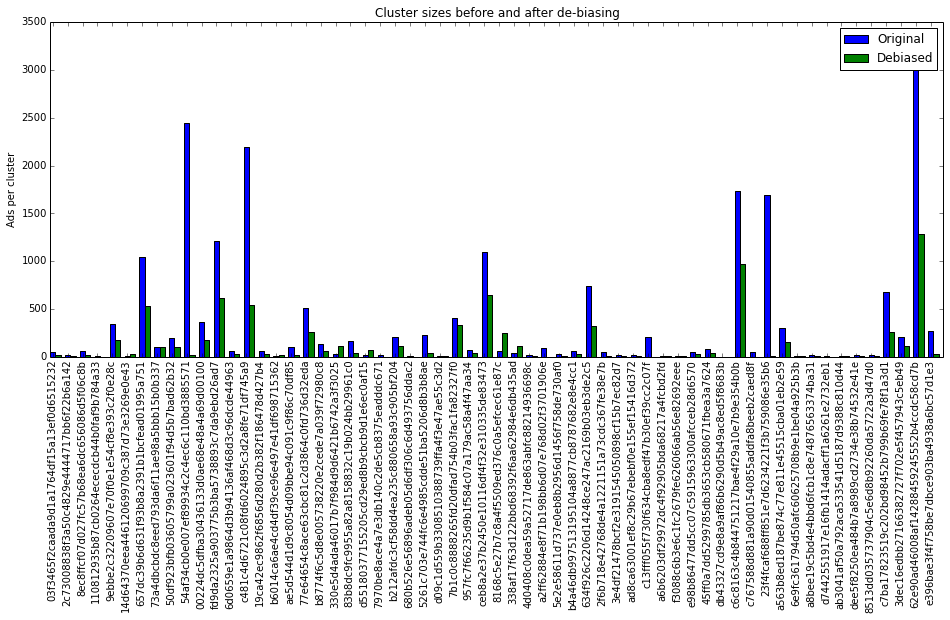

In [140]:
rcParams['figure.figsize'] = 16,6
start_idx = 160
end_idx = 220

N = len(labels[start_idx:end_idx])

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, orig[start_idx:end_idx], width, color='b')
rects2 = ax.bar(ind + width, debiased[start_idx:end_idx], width, color='g')

# add some text for labels, title and axes ticks
ax.set_ylabel('Ads per cluster')
ax.set_title('Cluster sizes before and after de-biasing')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(labels, rotation='vertical')

ax.legend((rects1[0], rects2[0]), ('Original', 'Debiased'))

### Predict using cluster size only

In [186]:
train_sizes = []
test_sizes = []

for _id in _all["train_ids"]:
    train_sizes.append([debiased_cluster_sizes[_id.replace("\n", "")]])
    
for _id in _all["test_ids"]:
    test_sizes.append([test_cluster_sizes[_id.replace("\n", "")]])

In [197]:
size_clf = LinearSVC()
size_clf.fit(train_sizes, _all["train_labels"])
size_preds = size_clf.predict(test_sizes)
size_preds_conf = size_clf.decision_function(test_sizes)

In [40]:
rcParams['figure.figsize'] = 8,6
# tprs, thresholds = plot_roc_auc(_all["test_labels"], size_preds_conf)

### Load SpaCy model and initiate transformer for Sklearn pipeline

In [6]:
nlp = spacy.load('en')

In [15]:
# Define a custom transformer to clean text using spaCy (needed for pipeline)
class CleanTextTransformer(TransformerMixin):
    """
    Clean and tokenize raw text.
    """

    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

### Clean, tokenize, de-bias further with NER

In [8]:
def clean_text(string):
    """
    Original taken from: 
    https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"\\n", " ", string)
    string = re.sub(r"\\t", " ", string)
    string = re.sub(r"\\", " ", string)
    string = re.sub(r"\d\d\d+", " ", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [293]:
def tokenize_text(text):
    """ Tokenize, use NER to remove locations and dates (possible 
    sources of bias), lemmatize, and remove stopwords.
    
    Args: 
        text (str): output of "extracted_text" field from 
                    CDR after passed through clean_string()
        
    Returns:
        list: cleaned set of tokens
    
    """
    
    for_removal = []

    # tokenize using spaCy
    doc = nlp(text)
    tokens = list(doc)
    
    #Remove locations and dates using NER
    for ent in doc.ents:
        if ent.label_ in ["GPE","DATE"]:
            for_removal.append(str(ent).lower())

            if " " in str(ent):
                for word in str(ent).split():
                    for_removal.append(word.lower())

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_ if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # remove stopwords
    tokens = [tok for tok in tokens if tok not in STOPLIST and tok not in for_removal]

    return tokens

### Combine raw ad-level data into cluster level data 

In [156]:
def agg_by_cluster(data_file, backpage_only=False):
    """ Aggregates ad text and labels up to cluster level, optionally 
    selecting only backpage ads.
    
    Args: 
        data_file (str): location of raw json lines data file
        backpage_only (bool): only retain ads from backpage (WIP)
    
    Returns:
        corpus (dict): cluster id as key, with labels, text for each cluster
        cluster_sizes (dict): {<label id>: <number of ads in cluster>}
    """
    
    corpus = {}
    cluster_sizes = {}

    with open(data_file, "r") as f:
        for ad in json_lines.reader(f):
            
#             ad_keywords = ad["_source"]["extracted_metadata"]["keywords"]
            extracted_text = json.dumps(ad["_source"]["extracted_text"])
            
#             if backpage_only == True and not "backpage" in ad_keywords.lower():
#                 break
            
            if not ad["cluster_id"] in corpus:
                corpus[ad["cluster_id"]] = {"text": extracted_text}
                                
                if "annotation" in ad:
                    label = 1 if ad["annotation"] == "VERY_RELEVANT" else 0
                    corpus[ad["cluster_id"]]["label"] = label
                    
                cluster_sizes[ad["cluster_id"]] = 1

            else:
                corpus[ad["cluster_id"]]["text"] += " " + extracted_text
                cluster_sizes[ad["cluster_id"]] += 1
    
    return corpus, cluster_sizes



def add_test_labels(ground_truth_file, corpus):
    """ Add labels to test data.
    
    Args: 
        ground_truth_file (str): location of json line file with
                                 cluster_ids and labels
        corpus (dict): Dictionary text, ids (and soon to be labels)
                       by cluster
        
    Returns:
        dict: corpus updated with labels for each cluster
    """                                                                                           
    
    label_lookup = {}
    
    with open(ground_truth_file, "r") as f:
        for line in json_lines.reader(f):
            label_lookup[line["cluster_id"]] = line["score"]
            
    for key, value in corpus.iteritems():
        corpus[key]["label"] = label_lookup[key]
        
    return corpus

In [170]:
_dir = "test-train-data/"

train_corp, train_cluster_sizes = agg_by_cluster(_dir + "debiased_training.json")
print "finished train"

test_corp, test_cluster_sizes = agg_by_cluster(_dir + "test_adjusted_unlabeled.json")
print "finished test"

# bp_test_corp, bp_test_cluster_sizes = agg_by_cluster(_dir + "test_adjusted_unlabeled.json", 
#                                                        backpage_only=True)
# print "finished bp"

test_corp = add_test_labels(_dir + "cp1_adjusted_ground_truth.json", test_corp)
# bp_test_corp = add_test_labels(_dir + "cp1_adjusted_ground_truth.json", bp_test_corp)

finished train
finished test


In [173]:
_all = {} # hold all lists

def make_lists(corpus, empty_clusters):
    """ Break up clusters dictionary into lists to 
    retain ordering throughout modeling.
    
    Args: 
        corpus (dict): dictionary of cluster info
        
    Returns:
        cluster_texts (list): combined raw ad texts for clusters
        cluster_labels (list): list of 1 or 0 (1 = HT, 0 = not HT)
        cluster_ids (list): cluster id from CDR
    """ 

    cluster_texts = []
    cluster_ids = []
    cluster_labels = []

    for key in corpus.keys():
        if not key in empty_clusters:
            cluster_texts.append(corpus[key]["text"])
            cluster_labels.append(corpus[key]["label"])
            cluster_ids.append(key)
    
    return cluster_texts, cluster_ids, cluster_labels

_all["train_texts"], _all["train_ids"], _all["train_labels"] = make_lists(train_corp, empty_clusters)
_all["test_texts"], _all["test_ids"], _all["test_labels"] = make_lists(test_corp, empty_clusters)
# _all["bp_test_texts"], _all["bp_test_ids"], _all["bp_test_labels"] = make_lists(bp_test_corp, empty_clusters)

### Write out preprocessed data

In [175]:
_dir = "preprocessed-data/"

def write_to_file(filepath, _list, jsonl=False):
    """ Write out lists so can start workflow from here.
    
    Args: 
        filepath (str): location of file to save
        jsonl (bool): If True, each line will contain json doc
                      If False, each line is string
        
    """ 
    with open(filepath, "w") as out:
        for x in _list:
            if jsonl == True:
                doc = {"text": x}
                out.write(json.dumps(doc) + "\n")
            else:
                out.write(str(x) + "\n")

# for split in ["train", "test", "bp_test"]:
for split in ["train", "test"]:
    for data_type in ["_texts", "_ids", "_labels"]:
        jsonl = True if data_type == "_texts" else False
        combo = split + data_type
        write_to_file(_dir + combo + ".txt", _all[combo], jsonl=jsonl)

### Load preprocessed data (Checkpoint)

In [23]:
_dir = "preprocessed-data/"
_all = {} # hold all lists

def load_from_file(filepath, empty_clusters, jsonl=False):
    """ Load lists so can start workflow from here.
    
    Args: 
        filepath (str): location of file to load
        jsonl (bool): If True, each line contains json doc. 
                      If False, each line is string
        
    Returns:
        list: list of values with len == num of lines
    """ 
    _list = []
    
    with open(filepath, "r") as f:
        for l in f.readlines():
            if jsonl == True:
                doc = json.loads(l)
                _list.append(doc["text"])
            else:
                if "labels" in filepath:
                    _list.append(int(l))
                elif "_ids" in filepath:
                    _list.append(l)
    
    return _list
                
for split in ["train", "test", "bp_test"]:
    for data_type in ["_texts", "_ids", "_labels"]:
        jsonl = True if data_type == "_texts" else False
        combo = split + data_type
        _all[combo] = load_from_file(_dir + combo + ".txt", 
                                     empty_clusters, jsonl=jsonl)

### Class distributions (and comparisons between de-biased and original training data)

In [69]:
_all["original_train_labels"] = []

clusters = []

with open("test-train-data/train_adjusted.json", "r") as f:
    for doc in json_lines.reader(f):
        if not doc["cluster_id"] in clusters:
            label = 1 if doc["annotation"] == "VERY_RELEVANT" else 0
            _all["original_train_labels"].append(label)
            clusters.append(doc["cluster_id"])
            
print "Original Training Info:"
print "=============="
print "Total clusters: %s" %len(_all["original_train_labels"])
print "Num positive clusters: %s" %sum(_all["original_train_labels"])
print "Num negative clusters: %s" %(len(_all["original_train_labels"]) - sum(_all["original_train_labels"]))

Original Training Info:
Total clusters: 614
Num positive clusters: 54
Num negative clusters: 560


In [71]:
print "De-Biased Training Info:"
print "=============="
print "Total clusters: %s" %len(_all["train_ids"])
print "Num positive clusters: %s" %sum(_all["train_labels"])
print "Num negative clusters: %s" %(len(_all["train_ids"]) - sum(_all["train_labels"]))

for i, _id in enumerate(_all["train_ids"]):
    if _id.replace("\n","") in empty_clusters:
        print _id.replace("\n","")

print
print "Num of clusters aligns with de-biasing instructions: " 
print str((len(_all["original_train_labels"]) - len(empty_clusters)) == len(_all["train_ids"]))

De-Biased Training Info:
Total clusters: 511
Num positive clusters: 53
Num negative clusters: 458

Num of clusters aligns with de-biasing instructions: 
True


In [39]:
print "Test Info:"
print "=============="
print "Total clusters: %s" %len(_all["test_ids"])
print "Num positive clusters: %s" %sum(_all["test_labels"])
print "Num negative clusters: %s" %(len(_all["test_ids"]) - sum(_all["test_labels"]))

Test Info:
Total clusters: 130
Num positive clusters: 25
Num negative clusters: 105


In [21]:
train, val, train_y, val_y = train_test_split(_all["train_texts"],
                                              _all["train_labels"],
                                              test_size=0.3,
                                              random_state=1)

print "Positive Training Clusters: %s" %sum(train_y)
print "Negative Training Clusters: %s" %(len(train_y) - sum(train_y))
print ""
print "Positive Validation Clusters: %s" %sum(val_y)
print "Negative Validation Clusters: %s" %(len(val_y) - sum(val_y))

Positive Training Clusters: 38
Negative Training Clusters: 325

Positive Validation Clusters: 15
Negative Validation Clusters: 141


# Classify using all features except custom stopwords 
### Custom stopwords = locations, names, source-specific info
-------

In [ ]:
with open("features/pos_biased_features.txt", "r") as f:
    ht_pos_stopwords = f.read().splitlines()    

with open("features/neg_biased_features.txt", "r") as f:
    ht_neg_stopwords = f.read().splitlines()

ht_stopwords = ht_pos_stopwords + ht_neg_stopwords
    
STOPLIST = set(stopwords.words('english') + ht_stopwords + list(ENGLISH_STOP_WORDS))

### Load previously trained model:

In [285]:
clf = joblib.load("models-vectors/model4.pkl")
vectorizer = joblib.load("models-vectors/vectorizer4.pkl")
# pipe = joblib.load("pipeline4.pkl")

### Train/save model (all features except custom stopwords)

In [ ]:
start = time.time()

# Slower, retain feature info
vectorizer = CountVectorizer(tokenizer=tokenize_text, 
                             ngram_range=(1,2), 
                             max_df=0.6, 
                             max_features=100000)

# Much faster, no feature importance available
# vectorizer = HashingVectorizer(tokenizer=tokenizeText, 
#                                ngram_range=(1,1), 
#                                n_features=5000)

tfidf = TfidfTransformer()
clf = LinearSVC()

pipe = Pipeline([('clean_text', CleanTextTransformer()), 
                 ('vectorizer', vectorizer), 
                 ('tfidf', tfidf), 
                 ('clf', clf)])

# train
pipe.fit(_all["train_texts"], _all["train_labels"])

print "Time to train: %s" %(time.time() - start)

In [ ]:
# save
joblib.dump(clf, 'models-vectors/model4.pkl')
joblib.dump(vectorizer, 'models-vectors/vectorizer4.pkl')
joblib.dump(tfidf, 'models-vectors/tfidf4.pkl')
joblib.dump(pipe, 'models-vectors/pipeline4.pkl')

### Predict confidences and save

In [ ]:
# prediction confidence

start = time.time()

test_preds_conf = pipe.decision_function(_all["test_texts"])
# val_preds = pipe.predict(val)
with open("predictions/prediction_confs4.txt", "w") as out:
    for c in test_preds_conf:
        out.write(str(c) + "\n")

print "Time to calculate confidences: %s" %(time.time() - start)

### Prediction class and save

In [ ]:
start = time.time()

test_preds = pipe.predict(_all["test_texts"])
# val_preds = pipe.predict(val)

print "Time to predict: %s" %(time.time() - start)

with open("predictions/predictions4.txt", "w") as out:
    for p in test_preds:
        out.write(str(p) + "\n")

### Load predictions and confidences

In [286]:
test_preds = [] # 0 or 1
test_preds_conf = [] # -1 to 1 (pos or neg depending on which side of hyperplane)

with open("predictions/prediction_confs4.txt", "r") as f:
    for c in f.readlines():
        test_preds_conf.append(float(c))
        
with open("predictions/predictions4.txt", "r") as f:
    for p in f.readlines():
        test_preds.append(int(p))

print test_preds[:10]
print test_preds_conf[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[-0.752446688946, -0.0147566396806, -0.285549270843, -0.631780817451, -0.932600831947, -0.501376761443, -0.950705615488, -0.796493532997, -0.481775335434, -0.552611267757]


## Evaluation (all features except custom stopwords)
-----

In [5]:
def plot_roc_auc(y, y_hat):

    fprs, tprs, thresholds = roc_curve(y, y_hat)
    roc_auc = roc_auc_score(y, y_hat)

    plt.figure()
    lw = 2
    plt.plot(fprs, tprs, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
    return tprs, thresholds

# plot_roc_auc(val_y, val_preds) 
# tprs, thresholds = plot_roc_auc(_all["test_labels"], test_preds_conf)

In [6]:
for x, y in zip(thresholds, tprs):
    if y > 0.8 and y < 0.9: # sweet spot based on chart
        print "threshold: %s" %x
        print "true positive rate: %s" %y
        print

In [289]:
adjusted_test_preds = [1 if x > -0.681175655649 else 0 for x in test_preds_conf]

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# test_cnf_matrix = confusion_matrix(_all["test_labels"], adjusted_test_preds)

# plt.figure()
# plot_confusion_matrix(test_cnf_matrix, classes=["0","1"], title="Test Data Results")

In [35]:
def top_features(vectorizer, clf, N, _class="pos", 
                 write_to_file=None, _print=False):
    """ Print most salient n-grams from the model.
    
    Args: 
        vectorizer (obj): Sklearn object containing vector info
        clf (obj): Sklearn (trained) classifier object
        N (int): Number of features/scores to print
    """
    
    features = vectorizer.get_feature_names()
    print "Number of features: %s" %clf.coef_.shape[1]
    
    coefs_with_fns = sorted(zip(clf.coef_[0], features))
    if _class == "neg":
        top = coefs_with_fns[:N]
    elif _class == "pos":
        top = coefs_with_fns[-N:]
        top.reverse()
    
    grams = []
    
    if write_to_file:
        with open("feature_importances/" + _class + "_" + write_to_file + ".txt", "w") as out:
            out.writelines("%s\n" %str(t) for t in top)

    if _print:
        for f in top:
            grams.append(f[1])
            print(f)
        
    return grams

In [291]:
top_pos_grams = top_features(vectorizer, clf, 150, _class="pos", 
                             write_to_file="all_feature_importances")

top_pos_grams = top_features(vectorizer, clf, 150, _class="neg", 
                             write_to_file="all_feature_importances")

# print top_pos_grams

Number of features: 100000
Number of features: 100000


# "Unbiased" features only (~390 total)
------

### Load curated "unbiased" features

In [12]:
with open("features/neg_unbiased_features.txt", "r") as f:
    neg_features = f.read().splitlines()
    
with open("features/pos_unbiased_features.txt", "r") as f:
    pos_features = f.read().splitlines()
    
unbiased_features = pos_features + neg_features

# Use "unbiased_tokens" to cut down on vectorizing time 
unbiased_tokens = []
for ngram in unbiased_features:
    if " " in ngram:
        for tok in ngram.split(" "):
            unbiased_tokens.append(tok)
    else:
        unbiased_tokens.append(ngram)

In [10]:
def unbiased_tokenizer(text):
    """ Tokenize, lemmatize, and only keep features identified
    as unbiased.
    
    Args: 
        text (str): output of "extracted_text" field from 
                    CDR after passed through clean_string()
        
    Returns:
        list: cleaned set of tokens
    
    """
    
    for_removal = []

    # tokenize using spaCy
    doc = nlp(text)
    tokens = list(doc)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_ if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # remove stopwords
    tokens = [tok for tok in tokens if tok in unbiased_tokens]
        
    
    return tokens

### Build classifier using only "unbiased" features

In [ ]:
start = time.time()

db_vectorizer = CountVectorizer(tokenizer=unbiased_tokenizer, 
                                ngram_range=(1,2), 
                                vocabulary=unbiased_features)

db_tfidf = TfidfTransformer()
db_clf = LinearSVC()

db_pipe = Pipeline([('clean_text', CleanTextTransformer()), 
                    ('vectorizer', db_vectorizer), 
                    ('tfidf', db_tfidf), 
                    ('clf', db_clf)])

db_pipe.fit(_all["train_texts"], _all["train_labels"])

print time.time() - start

In [ ]:
start = time.time()

test_preds_db = db_pipe.predict(_all["test_texts"])
test_preds_db_conf = db_pipe.decision_function(_all["test_texts"])

print time.time() - start

### Save pipeline and predictions

In [254]:
joblib.dump(db_clf, 'models-vectors/db_model.pkl')
joblib.dump(db_vectorizer, 'models-vectors/db_vectorizer.pkl')
joblib.dump(db_tfidf, 'models-vectors/db_tfidf.pkl')
joblib.dump(db_pipe, 'models-vectors/db_pipeline.pkl')

['models-vectors/db_pipeline.pkl']

In [33]:
with open("predictions/prediction_confs_db.txt", "w") as out:
    for c in test_preds_db_conf:
        out.write(str(c) + "\n")
        
with open("predictions/predictions_db.txt", "w") as out:
    for p in test_preds_db:
        out.write(str(p) + "\n")

### Load pipeline and predictions (for analysis)

In [16]:
db_clf = joblib.load('models-vectors/db_model.pkl')
db_vectorizer = joblib.load('models-vectors/db_vectorizer.pkl')
db_tfidf = joblib.load('models-vectors/db_tfidf.pkl')
db_pipe = joblib.load('models-vectors/db_pipeline.pkl')

In [28]:
with open("predictions/prediction_confs_db.txt", "r") as f:
    test_preds_db_conf = [float(x) for x in f.read().splitlines()]

with open("predictions/predictions_db.txt", "r") as f:
    test_preds_db = [int(x) for x in f.read().splitlines()]

### Evaluate "unbiased" features model

In [39]:
db_tprs, db_thresholds = plot_roc_auc(_all["test_labels"], 
                                      test_preds_db_conf)

In [38]:
for x, y in zip(db_thresholds, db_tprs):
    if y > 0.75 and y < 0.85: # sweet spot based on chart
        print "threshold: %s" %x
        print "true positive rate: %s" %y
        print

In [31]:
adjusted_db_test_preds = [1 if x > -0.698 else 0 for x in test_preds_db_conf]

In [37]:
# train_cnf_matrix = confusion_matrix(val_y, preds)
db_test_cnf_matrix = confusion_matrix(_all["test_labels"], adjusted_db_test_preds)

plt.figure()
# plot_confusion_matrix(train_cnf_matrix, classes=["0","1"], title="Test")
plot_confusion_matrix(db_test_cnf_matrix, classes=["0","1"], title="Test")

In [36]:
top_features(db_vectorizer, db_clf, 150, _class="neg", 
             write_to_file="unbiased_feature_importances")

top_features(db_vectorizer, db_clf, 150, _class="pos", 
             write_to_file="unbiased_feature_importances")

Number of features: 382
Number of features: 382


[]